In [1]:
import sqlite3
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

In [2]:
conn = sqlite3.connect('/Users/Merin/Desktop/HAP880/Assignment6/testClaims.db')

In [3]:
tbls = pd.read_sql('select * from sqlite_master', conn)

In [4]:
tbls

,type,name,tbl_name,rootpage,sql
0,table,claims,claims,2,"CREATE TABLE ""claims"" (\n""index"" INTEGER,\n ""..."
1,index,ix_claims_index,claims,3,"CREATE INDEX ""ix_claims_index""ON ""claims"" (""in..."
2,table,d_elixhauser,d_elixhauser,171943,"CREATE TABLE ""d_elixhauser"" (\n""index"" INTEGER..."
3,index,ix_d_elixhauser_index,d_elixhauser,171944,"CREATE INDEX ""ix_d_elixhauser_index""ON ""d_elix..."
4,table,d_placeOfService,d_placeOfService,171964,"CREATE TABLE ""d_placeOfService"" (\n""index"" INT..."
5,index,ix_d_placeOfService_index,d_placeOfService,171965,"CREATE INDEX ""ix_d_placeOfService_index""ON ""d_..."
6,table,diagnoses,diagnoses,171966,"CREATE TABLE ""diagnoses"" (\n""index"" INTEGER,\n..."
7,index,ix_diagnoses_index,diagnoses,171967,"CREATE INDEX ""ix_diagnoses_index""ON ""diagnoses..."
8,table,drugcount,drugcount,385252,"CREATE TABLE ""drugcount"" (\n""index"" INTEGER,\n..."
9,index,ix_drugcount_index,drugcount,385253,"CREATE INDEX ""ix_drugcount_index""ON ""drugcount..."


In [5]:
claims = pd.read_sql('select * from claims', con=conn, index_col="index")

In [6]:
claims[:10]

,claim_id,patient_id,los,provider,plcsrvc,months,year,claim_days
index,,,,,,,,
0,11,PAT110736,NaN,None,15,0-1,Y3,19
1,110,PAT24603,NaN,None,15,8-9,Y3,260
2,1100137,PAT126045,NaN,None,15,4-5,Y3,149
3,1100138,PAT126045,NaN,None,15,4-5,Y3,149
4,1100140,PAT21309,NaN,None,15,8-9,Y3,258
5,1100150,PAT39615,NaN,None,15,6-7,Y3,206
6,1100151,PAT39615,NaN,None,15,6-7,Y3,206
7,1100156,PAT39615,NaN,None,15,7-8,Y3,237
8,1100157,PAT39615,NaN,None,15,7-8,Y3,237


In [7]:
# that may be too big to load ... depnds on computer
diagnoses = pd.read_sql('select * from diagnoses', con=conn, index_col="index")

In [8]:
claims['cum_days']=claims.apply(lambda r: (int(r["year"][1])-1)*365+r['claim_days'], axis=1)

In [9]:
gr_pat=claims.groupby("patient_id")

In [10]:
pat = pd.DataFrame()
pat['min_days']=gr_pat["cum_days"].min()
pat['max_days']=gr_pat["cum_days"].max()
pat[:10]

,min_days,max_days
patient_id,,
PAT10,26,1068
PAT100,11,625
PAT1000,707,707
PAT10000,52,915
PAT100001,263,263
PAT100002,65,78
PAT100003,13,1079
PAT100004,37,1056
PAT100005,86,1059


In [11]:
# pull data for one patient in a given timeframe
back_window = 120
time = 1000
patient = 'PAT10'

In [12]:
# claims in a given time period
cl = claims[(claims['patient_id'] == patient) & 
       (claims['cum_days'] >= time - back_window) &
       (claims['cum_days'] < time)]

In [13]:
# pull diagnosis groups for these claims
diag = diagnoses.join(cl.set_index("claim_id"), on="claim_id", how='right')

In [14]:
# group by to binarize codes
dg = diag.groupby("patient_id")
dg

In [15]:
diag[:20]

,claim_id,diagnosis,dgn_sequence,patient_id,los,provider,plcsrvc,months,year,claim_days,cum_days
index,,,,,,,,,,,
5636,1109680,ELIX3,1,PAT10,NaN,None,15,5-6,Y3,178,908
4553086,515703916,ELIX26,4,PAT10,NaN,None,28,5-6,Y3,154,884
4553087,515703917,ELIX26,4,PAT10,NaN,None,28,5-6,Y3,154,884
4553088,515703918,ELIX26,4,PAT10,NaN,None,28,5-6,Y3,154,884
4553089,515703927,ELIX26,3,PAT10,NaN,None,28,6-7,Y3,196,926
4553090,515703928,ELIX26,3,PAT10,NaN,None,28,6-7,Y3,196,926
4553091,515703929,ELIX26,3,PAT10,NaN,None,28,6-7,Y3,196,926
4553092,515703930,ELIX26,3,PAT10,NaN,None,28,6-7,Y3,196,926
4553093,515703931,ELIX26,2,PAT10,NaN,None,28,7-8,Y3,240,970


In [16]:
dg['diagnosis'].max()

patient_id
PAT10    ELIX3
Name: diagnosis, dtype: object

In [17]:
pd.pivot_table(diag, values='dgn_sequence', index=['patient_id'],
                     columns=['diagnosis'], aggfunc=np.min, fill_value=0)

diagnosis,ELIX26,ELIX3
patient_id,,
PAT10,1,1


In [18]:
pat1=pd.DataFrame(pat[pat['min_days'] < pat['max_days']])

In [19]:
# pull data for all patients
back_window = 120
pat1['rand_days']=pat1.apply(lambda r: np.random.randint(r['min_days'],r['max_days']),axis=1)

In [20]:
claims=pd.merge(claims,pd.DataFrame(pat1['rand_days']), left_on='patient_id', right_index=True, how="inner")

In [21]:
claims[:10]

,claim_id,patient_id,los,provider,plcsrvc,months,year,claim_days,cum_days,rand_days
index,,,,,,,,,,
0,11,PAT110736,NaN,None,15,0-1,Y3,19,749,235
50557,12,PAT110736,NaN,None,15,1-2,Y3,50,780,235
325297,4134621,PAT110736,4.0,PRV13117,20,10-11,Y3,310,1040,235
405754,455130,PAT110736,9.0,PRV5556,20,11-12,Y1,340,340,235
2021923,513977132,PAT110736,NaN,None,28,0-1,Y3,24,754,235
2021924,513977133,PAT110736,NaN,None,28,0-1,Y3,24,754,235
2021925,513977134,PAT110736,NaN,None,28,0-1,Y3,24,754,235
2021926,513977135,PAT110736,NaN,None,28,0-1,Y3,24,754,235
2021927,513977136,PAT110736,NaN,None,28,0-1,Y3,24,754,235


In [22]:
claims[(claims['rand_days']-back_window <= claims['cum_days'])
      & (claims['rand_days'] > claims['cum_days'])][:10]

,claim_id,patient_id,los,provider,plcsrvc,months,year,claim_days,cum_days,rand_days
index,,,,,,,,,,
6168432,5531,PAT110736,NaN,None,28,6-7,Y1,191,191,235
6171492,5532,PAT110736,NaN,None,28,6-7,Y1,191,191,235
7944957,5982,PAT24603,NaN,None,28,5-6,Y2,172,537,574
7949581,5983,PAT24603,NaN,None,28,5-6,Y2,172,537,574
7953504,5984,PAT24603,NaN,None,28,5-6,Y2,172,537,574
7958159,5985,PAT24603,NaN,None,28,5-6,Y2,172,537,574
8173023,61309337,PAT126045,NaN,PRV2704,30,10-11,Y2,311,676,788
8173024,61309338,PAT126045,NaN,PRV2704,30,10-11,Y2,311,676,788
8173025,61309339,PAT126045,NaN,PRV2704,30,10-11,Y2,311,676,788


In [23]:
sel_claims = claims[(claims['rand_days']-back_window <= claims['cum_days'])
      & (claims['rand_days'] > claims['cum_days'])]

In [24]:
sel_claims[:10]

,claim_id,patient_id,los,provider,plcsrvc,months,year,claim_days,cum_days,rand_days
index,,,,,,,,,,
6168432,5531,PAT110736,NaN,None,28,6-7,Y1,191,191,235
6171492,5532,PAT110736,NaN,None,28,6-7,Y1,191,191,235
7944957,5982,PAT24603,NaN,None,28,5-6,Y2,172,537,574
7949581,5983,PAT24603,NaN,None,28,5-6,Y2,172,537,574
7953504,5984,PAT24603,NaN,None,28,5-6,Y2,172,537,574
7958159,5985,PAT24603,NaN,None,28,5-6,Y2,172,537,574
8173023,61309337,PAT126045,NaN,PRV2704,30,10-11,Y2,311,676,788
8173024,61309338,PAT126045,NaN,PRV2704,30,10-11,Y2,311,676,788
8173025,61309339,PAT126045,NaN,PRV2704,30,10-11,Y2,311,676,788


In [25]:
pd.merge(sel_claims,pd.DataFrame(diagnoses.set_index('claim_id')['diagnosis']), 
         left_on='claim_id', right_index=True, how="left")[:10]

,claim_id,patient_id,los,provider,plcsrvc,months,year,claim_days,cum_days,rand_days,diagnosis
index,,,,,,,,,,,
6168432,5531,PAT110736,NaN,None,28,6-7,Y1,191,191,235,ELIX1
6168432,5531,PAT110736,NaN,None,28,6-7,Y1,191,191,235,ELIX20
6168432,5531,PAT110736,NaN,None,28,6-7,Y1,191,191,235,ELIX26
6171492,5532,PAT110736,NaN,None,28,6-7,Y1,191,191,235,ELIX1
6171492,5532,PAT110736,NaN,None,28,6-7,Y1,191,191,235,ELIX20
6171492,5532,PAT110736,NaN,None,28,6-7,Y1,191,191,235,ELIX26
7944957,5982,PAT24603,NaN,None,28,5-6,Y2,172,537,574,ELIX27
7944957,5982,PAT24603,NaN,None,28,5-6,Y2,172,537,574,ELIX3
7944957,5982,PAT24603,NaN,None,28,5-6,Y2,172,537,574,ELIX5


In [26]:
sel_diag=pd.merge(sel_claims,diagnoses.set_index('claim_id')[['diagnosis','dgn_sequence']], 
                  left_on='claim_id', right_index=True, how="left")

In [27]:
sel_diag[:10]

,claim_id,patient_id,los,provider,plcsrvc,months,year,claim_days,cum_days,rand_days,diagnosis,dgn_sequence
index,,,,,,,,,,,,
6168432,5531,PAT110736,NaN,None,28,6-7,Y1,191,191,235,ELIX1,3
6168432,5531,PAT110736,NaN,None,28,6-7,Y1,191,191,235,ELIX20,2
6168432,5531,PAT110736,NaN,None,28,6-7,Y1,191,191,235,ELIX26,1
6171492,5532,PAT110736,NaN,None,28,6-7,Y1,191,191,235,ELIX1,3
6171492,5532,PAT110736,NaN,None,28,6-7,Y1,191,191,235,ELIX20,2
6171492,5532,PAT110736,NaN,None,28,6-7,Y1,191,191,235,ELIX26,1
7944957,5982,PAT24603,NaN,None,28,5-6,Y2,172,537,574,ELIX27,2
7944957,5982,PAT24603,NaN,None,28,5-6,Y2,172,537,574,ELIX3,4
7944957,5982,PAT24603,NaN,None,28,5-6,Y2,172,537,574,ELIX5,3


In [28]:
elix=pd.pivot_table(sel_diag, values='dgn_sequence', index=['patient_id'],
                     columns=['diagnosis'], aggfunc=np.min, fill_value=0)

elix[:10]

diagnosis,ELIX1,ELIX10,ELIX11,ELIX12,ELIX13,ELIX14,ELIX15,ELIX16,ELIX17,ELIX18,...,ELIX27,ELIX28,ELIX29,ELIX3,ELIX4,ELIX5,ELIX6,ELIX7,ELIX8,ELIX9
patient_id,,,,,,,,,,,,,,,,,,,,,
PAT10,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PAT100,0,0,0,0,0,4,0,0,0,0,...,0,0,1,2,0,0,0,0,5,0
PAT100002,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,0
PAT100003,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
PAT100004,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,2,0,0,0,0
PAT100007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
PAT100008,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,3
PAT10001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PAT100011,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
elix = pd.get_dummies(sel_diag['diagnosis']).groupby(sel_diag['patient_id'],as_index='patient_id').max()
elix[:10]

,ELIX1,ELIX10,ELIX11,ELIX12,ELIX13,ELIX14,ELIX15,ELIX16,ELIX17,ELIX18,...,ELIX27,ELIX28,ELIX29,ELIX3,ELIX4,ELIX5,ELIX6,ELIX7,ELIX8,ELIX9
patient_id,,,,,,,,,,,,,,,,,,,,,
PAT10,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PAT100,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
PAT100002,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
PAT100003,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
PAT100004,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
PAT100007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
PAT100008,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
PAT10001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PAT100011,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
pat1[:10]

,min_days,max_days,rand_days
patient_id,,,
PAT10,26,1068,257
PAT100,11,625,205
PAT10000,52,915,187
PAT100002,65,78,71
PAT100003,13,1079,1032
PAT100004,37,1056,437
PAT100005,86,1059,676
PAT100007,26,1089,144
PAT100008,370,1034,883


In [33]:
conn.execute("""drop table pat1""")
pat1.to_sql('pat1',conn)

In [34]:
conn.execute("""drop table claims1""")
claims.to_sql('claims1',conn)

In [35]:
cmd = """create table binary_patients_Y1 as select c.patient_id,
Max(case when diagnosis = 'ELIX1' then 1 else 0 end) as ELIX1,
Max(case when diagnosis = 'ELIX2' then 1 else 0 end) as ELIX2,
Max(case when diagnosis = 'ELIX3' then 1 else 0 end) as ELIX3,
Max(case when diagnosis = 'ELIX4' then 1 else 0 end) as ELIX4,
Max(case when diagnosis = 'ELIX5' then 1 else 0 end) as ELIX5,
Max(case when diagnosis = 'ELIX6' then 1 else 0 end) as ELIX6,
Max(case when diagnosis = 'ELIX7' then 1 else 0 end) as ELIX7,
Max(case when diagnosis = 'ELIX8' then 1 else 0 end) as ELIX8,
Max(case when diagnosis = 'ELIX9' then 1 else 0 end) as ELIX9,
Max(case when diagnosis = 'ELIX10' then 1 else 0 end) as ELIX10,
Max(case when diagnosis = 'ELIX11' then 1 else 0 end) as ELIX11,
Max(case when diagnosis = 'ELIX12' then 1 else 0 end) as ELIX12,
Max(case when diagnosis = 'ELIX13' then 1 else 0 end) as ELIX13,
Max(case when diagnosis = 'ELIX14' then 1 else 0 end) as ELIX14,
Max(case when diagnosis = 'ELIX15' then 1 else 0 end) as ELIX15,
Max(case when diagnosis = 'ELIX16' then 1 else 0 end) as ELIX16,
Max(case when diagnosis = 'ELIX17' then 1 else 0 end) as ELIX17,
Max(case when diagnosis = 'ELIX18' then 1 else 0 end) as ELIX18,
Max(case when diagnosis = 'ELIX19' then 1 else 0 end) as ELIX19,
Max(case when diagnosis = 'ELIX20' then 1 else 0 end) as ELIX20,
Max(case when diagnosis = 'ELIX21' then 1 else 0 end) as ELIX21,
Max(case when diagnosis = 'ELIX22' then 1 else 0 end) as ELIX22,
Max(case when diagnosis = 'ELIX23' then 1 else 0 end) as ELIX23,
Max(case when diagnosis = 'ELIX24' then 1 else 0 end) as ELIX24,
Max(case when diagnosis = 'ELIX25' then 1 else 0 end) as ELIX25,
Max(case when diagnosis = 'ELIX26' then 1 else 0 end) as ELIX26,
Max(case when diagnosis = 'ELIX27' then 1 else 0 end) as ELIX27,
Max(case when diagnosis = 'ELIX28' then 1 else 0 end) as ELIX28,
Max(case when diagnosis = 'ELIX29' then 1 else 0 end) as ELIX29

from diagnoses as d, claims1 as c, pat1 as p
where c.claim_id = d.claim_id and p.patient_id = c.patient_id and c.cum_days < p.rand_days and c.cum_days >= p.rand_days - 120

GROUP BY c.patient_id
"""

In [36]:
cmd = """drop table binary_patients_Y1"""

In [37]:
conn.execute(cmd)

### Assignment 6

### 1. Get access to MIMIC III data
#### - Access to MIMIC III database is obtained after the training.

### 2. Write 2-3 paragraphs report on progress on your final project
#### - The final project I am doing is on predicting the Length of Stay at Hospitals as a Classification model using average and median for Length of Stays. For the model, length of stays more than or equal to average and median of LOS is categorized as one class and less than the average or median of LOS is categorized as another class.
#### I am planning to use feature selection methods like chi2 stats and mutual info classification to improve the model results, but its also about how much of trade off we are planning to have.
#### Would be using atleast 3-4 models to compare the results and evaluate.

### 3. Using testClaims data compare models created by sampling data: random one, random many, sliding window. Decide on parameters of these methods.

In [40]:
def Patient_claims (back_window, time, patient, claims, diagnoses):
    #claims2 = pd.DataFrame(claims)
    #claims2 = claims2[(claims2['patient_id'] == patient) & (claims2['cum_days'] >= time - back_window) & (claims2['cum_days'] < time)]
    #diag = diagnoses.join(cl.set_index("claim_id"), on="claim_id", how='right')
    pat1['rand_days']=pat1.apply(lambda r: np.random.randint(r['min_days'],r['max_days']),axis=1)
    claims1=pd.merge(claims,pd.DataFrame(pat1['rand_days']), left_on='patient_id', right_index=True, how="inner")
    #conn.execute("""drop table pat1""")
    #conn.execute("""drop table claims1""")
    pat1.to_sql('pat1',conn)
    claims1.to_sql('claims1',conn)
    return;
        
def High_utilizer():
    cmd = """create table new_claims as select patient_id, count(distinct claim_id) as no_of_claims 
    from claims1
    group by patient_id"""
    #conn.execute("""drop table new_claims""")
    conn.execute(cmd)
    High_util = pd.read_sql('select * from new_claims', con=conn, index_col="patient_id")
    High_util.reset_index(inplace = True)
    High_util['High_Utilizer'] = np.where(High_util['no_of_claims']<=100, 0, 1)
    conn.execute("""drop table High_util""")
    High_util.to_sql('High_util',conn)
    return;
        
def Elix(back_window):
    cmd = """create table binary_patients_Y1 as select c.patient_id,
    Max(case when diagnosis = 'ELIX1' then 1 else 0 end) as ELIX1,
    Max(case when diagnosis = 'ELIX2' then 1 else 0 end) as ELIX2,
    Max(case when diagnosis = 'ELIX3' then 1 else 0 end) as ELIX3,
    Max(case when diagnosis = 'ELIX4' then 1 else 0 end) as ELIX4,
    Max(case when diagnosis = 'ELIX5' then 1 else 0 end) as ELIX5,
    Max(case when diagnosis = 'ELIX6' then 1 else 0 end) as ELIX6,
    Max(case when diagnosis = 'ELIX7' then 1 else 0 end) as ELIX7,
    Max(case when diagnosis = 'ELIX8' then 1 else 0 end) as ELIX8,
    Max(case when diagnosis = 'ELIX9' then 1 else 0 end) as ELIX9,
    Max(case when diagnosis = 'ELIX10' then 1 else 0 end) as ELIX10,
    Max(case when diagnosis = 'ELIX11' then 1 else 0 end) as ELIX11,
    Max(case when diagnosis = 'ELIX12' then 1 else 0 end) as ELIX12,
    Max(case when diagnosis = 'ELIX13' then 1 else 0 end) as ELIX13,
    Max(case when diagnosis = 'ELIX14' then 1 else 0 end) as ELIX14,
    Max(case when diagnosis = 'ELIX15' then 1 else 0 end) as ELIX15,
    Max(case when diagnosis = 'ELIX16' then 1 else 0 end) as ELIX16,
    Max(case when diagnosis = 'ELIX17' then 1 else 0 end) as ELIX17,
    Max(case when diagnosis = 'ELIX18' then 1 else 0 end) as ELIX18,
    Max(case when diagnosis = 'ELIX19' then 1 else 0 end) as ELIX19,
    Max(case when diagnosis = 'ELIX20' then 1 else 0 end) as ELIX20,
    Max(case when diagnosis = 'ELIX21' then 1 else 0 end) as ELIX21,
    Max(case when diagnosis = 'ELIX22' then 1 else 0 end) as ELIX22,
    Max(case when diagnosis = 'ELIX23' then 1 else 0 end) as ELIX23,
    Max(case when diagnosis = 'ELIX24' then 1 else 0 end) as ELIX24,
    Max(case when diagnosis = 'ELIX25' then 1 else 0 end) as ELIX25,
    Max(case when diagnosis = 'ELIX26' then 1 else 0 end) as ELIX26,
    Max(case when diagnosis = 'ELIX27' then 1 else 0 end) as ELIX27,
    Max(case when diagnosis = 'ELIX28' then 1 else 0 end) as ELIX28,
    Max(case when diagnosis = 'ELIX29' then 1 else 0 end) as ELIX29
    from diagnoses as d, claims1 as c, pat1 as p
    where c.claim_id = d.claim_id and p.patient_id = c.patient_id and c.cum_days < p.rand_days 
    and c.cum_days >= p.rand_days -"""
    cmd = cmd + " " + str(back_window)

    cmd = cmd + "\nGROUP BY c.patient_id"
    #conn.execute("""drop table binary_patients_Y1""")
    conn.execute(cmd)
    return;

def Glue():
    cmd = """create table High_utilization as select binary_patients_y1.*, High_util.patient_id, High_util.High_utilizer
    from binary_patients_y1
    join High_util
    on High_util.patient_id = binary_patients_y1.patient_id"""
    #conn.execute("""drop table High_utilization""")
    conn.execute(cmd)
    High_utilization = pd.read_sql('select * from High_utilization', con=conn, index_col="patient_id")
    return High_utilization;


#### Random many

In [32]:
conn = sqlite3.connect('/Users/Merin/Desktop/HAP880/Assignment6/testClaims.db')

In [33]:
claims = pd.read_sql('select * from claims', con=conn, index_col="index")
diagnoses = pd.read_sql('select * from diagnoses', con=conn, index_col="index")
claims['cum_days']=claims.apply(lambda r: (int(r["year"][1])-1)*365+r['claim_days'], axis=1)
gr_pat=claims.groupby("patient_id")

In [34]:
pat = pd.DataFrame()
pat['min_days']=gr_pat["cum_days"].min()
pat['max_days']=gr_pat["cum_days"].max()
pat1=pd.DataFrame(pat[pat['min_days'] < pat['max_days']])
pat1['patient_id2'] = pat1.index

In [41]:
import random
back_window = 120
time = 1000
rand_patient = random.choice(list(pat1['patient_id2']))

#Function calls
Patient_claims(back_window,time,rand_patient,claims,diagnoses)
print("Done Patient_claims")
High_utilizer()
print("Done High_utilizer")
Elix(back_window)
print("Done Elix")
HighUtilization = Glue()
HighUtilization[:10]

Done Patient_claims
Done High_utilizer
Done Elix


,ELIX1,ELIX2,ELIX3,ELIX4,ELIX5,ELIX6,ELIX7,ELIX8,ELIX9,ELIX10,...,ELIX22,ELIX23,ELIX24,ELIX25,ELIX26,ELIX27,ELIX28,ELIX29,patient_id:1,High_Utilizer
patient_id,,,,,,,,,,,,,,,,,,,,,
PAT10,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,PAT10,0
PAT100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,PAT100,1
PAT10000,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,PAT10000,0
PAT100002,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,PAT100002,0
PAT100003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,PAT100003,1
PAT100004,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,PAT100004,0
PAT100005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,PAT100005,0
PAT100008,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,PAT100008,0
PAT100011,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,PAT100011,1


#### Random one

In [57]:
rand_one_patient = random.choice(list(HighUtilization['patient_id:1']))
HighUtilization[HighUtilization['patient_id:1']==rand_one_patient]

,ELIX1,ELIX2,ELIX3,ELIX4,ELIX5,ELIX6,ELIX7,ELIX8,ELIX9,ELIX10,...,ELIX22,ELIX23,ELIX24,ELIX25,ELIX26,ELIX27,ELIX28,ELIX29,patient_id:1,High_Utilizer
patient_id,,,,,,,,,,,,,,,,,,,,,
PAT86803,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,PAT86803,1


#### Sliding window

In [66]:
def Patient_claims2 (back_window, time, patient, claims, diagnoses):
    #claims2 = pd.DataFrame(claims)
    #claims2 = claims2[(claims2['patient_id'] == patient) & (claims2['cum_days'] >= time - back_window) & (claims2['cum_days'] < time)]
    #diag = diagnoses.join(cl.set_index("claim_id"), on="claim_id", how='right')
    pat1['rand_days']=pat1.apply(lambda r: np.random.randint(r['min_days'],r['max_days']),axis=1)
    claims1=pd.merge(claims,pd.DataFrame(pat1['rand_days']), left_on='patient_id', right_index=True, how="inner")
    #conn.execute("""drop table pat1""")
    #conn.execute("""drop table claims1""")
    pat1.to_sql('pat1',conn)
    claims1.to_sql('claims1',conn)
    return;
        
def High_utilizer2 ():
    cmd = """create table new_claims as select patient_id, count(distinct claim_id) as no_of_claims 
    from claims1
    group by patient_id"""
    conn.execute("""drop table new_claims""")
    conn.execute(cmd)
    High_util = pd.read_sql('select * from new_claims', con=conn, index_col="patient_id")
    High_util.reset_index(inplace = True)
    High_util['High_Utilizer'] = np.where(High_util['no_of_claims']<=100, 0, 1)
    conn.execute("""drop table High_util""")
    High_util.to_sql('High_util',conn)
    return;
        
def Elix2(back_window):
    for back_window in range (11,31,5):
        conn.execute("""drop table binary_patients_Y1""")
        cmd = """create table binary_patients_Y1 as select c.patient_id,
        Max(case when diagnosis = 'ELIX1' then 1 else 0 end) as ELIX1,
        Max(case when diagnosis = 'ELIX2' then 1 else 0 end) as ELIX2,
        Max(case when diagnosis = 'ELIX3' then 1 else 0 end) as ELIX3,
        Max(case when diagnosis = 'ELIX4' then 1 else 0 end) as ELIX4,
        Max(case when diagnosis = 'ELIX5' then 1 else 0 end) as ELIX5,
        Max(case when diagnosis = 'ELIX6' then 1 else 0 end) as ELIX6,
        Max(case when diagnosis = 'ELIX7' then 1 else 0 end) as ELIX7,
        Max(case when diagnosis = 'ELIX8' then 1 else 0 end) as ELIX8,
        Max(case when diagnosis = 'ELIX9' then 1 else 0 end) as ELIX9,
        Max(case when diagnosis = 'ELIX10' then 1 else 0 end) as ELIX10,
        Max(case when diagnosis = 'ELIX11' then 1 else 0 end) as ELIX11,
        Max(case when diagnosis = 'ELIX12' then 1 else 0 end) as ELIX12,
        Max(case when diagnosis = 'ELIX13' then 1 else 0 end) as ELIX13,
        Max(case when diagnosis = 'ELIX14' then 1 else 0 end) as ELIX14,
        Max(case when diagnosis = 'ELIX15' then 1 else 0 end) as ELIX15,
        Max(case when diagnosis = 'ELIX16' then 1 else 0 end) as ELIX16,
        Max(case when diagnosis = 'ELIX17' then 1 else 0 end) as ELIX17,
        Max(case when diagnosis = 'ELIX18' then 1 else 0 end) as ELIX18,
        Max(case when diagnosis = 'ELIX19' then 1 else 0 end) as ELIX19,
        Max(case when diagnosis = 'ELIX20' then 1 else 0 end) as ELIX20,
        Max(case when diagnosis = 'ELIX21' then 1 else 0 end) as ELIX21,
        Max(case when diagnosis = 'ELIX22' then 1 else 0 end) as ELIX22,
        Max(case when diagnosis = 'ELIX23' then 1 else 0 end) as ELIX23,
        Max(case when diagnosis = 'ELIX24' then 1 else 0 end) as ELIX24,
        Max(case when diagnosis = 'ELIX25' then 1 else 0 end) as ELIX25,
        Max(case when diagnosis = 'ELIX26' then 1 else 0 end) as ELIX26,
        Max(case when diagnosis = 'ELIX27' then 1 else 0 end) as ELIX27,
        Max(case when diagnosis = 'ELIX28' then 1 else 0 end) as ELIX28,
        Max(case when diagnosis = 'ELIX29' then 1 else 0 end) as ELIX29
        from diagnoses as d, claims1 as c, pat1 as p
        where c.claim_id = d.claim_id and p.patient_id = c.patient_id and c.cum_days < p.rand_days 
        and c.cum_days >= p.rand_days -"""
        cmd = cmd + " " + str(back_window)
        cmd = cmd + "\nGROUP BY c.patient_id"
        conn.execute(cmd)
        #conn.execute(""" create table new_table as select * from binary_patients_Y1""")
        conn.execute(""" insert into new_table select * from binary_patients_Y1""")
    return;

def Glue2():
    cmd = """create table High_utilization as select new_table.*, High_util.patient_id, High_util.High_utilizer
    from new_table
    join High_util
    on High_util.patient_id = new_table.patient_id"""
    conn.execute("""drop table High_utilization""")
    conn.execute(cmd)
    High_utilization = pd.read_sql('select * from High_utilization', con=conn, index_col="patient_id")
    return High_utilization;

In [67]:
import random
time = 1000
rand_patient = random.choice(list(pat1['patient_id2']))

#Function calls
Patient_claims2(back_window,time,rand_patient,claims,diagnoses)
print("Done Patient_claims")
High_utilizer2()
print("Done High_utilizer")
Elix2(back_window)
print("Done Elix")
HighUtilization2 = Glue2()
HighUtilization2[:10]

Done Elix


,ELIX1,ELIX2,ELIX3,ELIX4,ELIX5,ELIX6,ELIX7,ELIX8,ELIX9,ELIX10,...,ELIX22,ELIX23,ELIX24,ELIX25,ELIX26,ELIX27,ELIX28,ELIX29,patient_id:1,High_Utilizer
patient_id,,,,,,,,,,,,,,,,,,,,,
PAT100002,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,PAT100002,0
PAT100013,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,1,0,0,PAT100013,1
PAT100023,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,PAT100023,1
PAT100025,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,PAT100025,0
PAT10003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,PAT10003,0
PAT10004,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,PAT10004,0
PAT100041,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,PAT100041,1
PAT100042,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,PAT100042,1
PAT10005,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,1,0,0,PAT10005,1


### 4. What is the optimal size of window (look back) for predicting high utilization in the following year. Demonstrate complete optimization process.

#### For each look back window value we find the AUCs and plot on a graph. The best AUC value represents the optimal size of window.

In [57]:
HighUtilization = HighUtilization.drop(['patient_id:1'], axis=1)

In [44]:
def distort(fff):
    trD = pd.DataFrame(fff)
    sz=len(trD.index)
    ELIX = (np.random.rand(sz,29) < 0.05).astype('int')
    trD.loc[:][['ELIX1','ELIX2','ELIX3','ELIX4','ELIX5','ELIX6','ELIX7','ELIX8','ELIX9','ELIX10','ELIX11','ELIX12',
     'ELIX13','ELIX14','ELIX15','ELIX16','ELIX17','ELIX18','ELIX19','ELIX20','ELIX21','ELIX22','ELIX23',
     'ELIX24','ELIX25','ELIX26','ELIX27','ELIX28','ELIX29']] -= ELIX
    trD.loc[:][['ELIX1','ELIX2','ELIX3','ELIX4','ELIX5','ELIX6','ELIX7','ELIX8','ELIX9','ELIX10','ELIX11','ELIX12',
     'ELIX13','ELIX14','ELIX15','ELIX16','ELIX17','ELIX18','ELIX19','ELIX20','ELIX21','ELIX22','ELIX23',
     'ELIX24','ELIX25','ELIX26','ELIX27','ELIX28','ELIX29']] = abs(trD.loc[:][['ELIX1','ELIX2','ELIX3','ELIX4','ELIX5','ELIX6','ELIX7','ELIX8','ELIX9','ELIX10','ELIX11','ELIX12',
     'ELIX13','ELIX14','ELIX15','ELIX16','ELIX17','ELIX18','ELIX19','ELIX20','ELIX21','ELIX22','ELIX23',
     'ELIX24','ELIX25','ELIX26','ELIX27','ELIX28','ELIX29']])
    return trD

In [45]:
dst = []
for i in range(10): 
    dst.append( distort(HighUtilization))

In [46]:
dstTr = pd.concat(dst)

In [47]:
cls = dstTr.columns

In [49]:
cls.drop('High_Utilizer')

Index(['ELIX1', 'ELIX2', 'ELIX3', 'ELIX4', 'ELIX5', 'ELIX6', 'ELIX7', 'ELIX8',
       'ELIX9', 'ELIX10', 'ELIX11', 'ELIX12', 'ELIX13', 'ELIX14', 'ELIX15',
       'ELIX16', 'ELIX17', 'ELIX18', 'ELIX19', 'ELIX20', 'ELIX21', 'ELIX22',
       'ELIX23', 'ELIX24', 'ELIX25', 'ELIX26', 'ELIX27', 'ELIX28', 'ELIX29'],
      dtype='object')

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [59]:
tr, ts = train_test_split(dstTr, test_size=0.2)

1.0


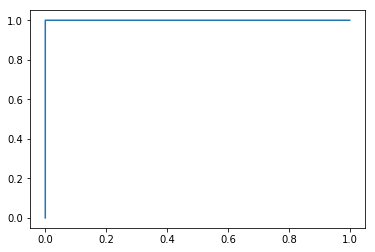

In [60]:
# logistic Regression
lr = LogisticRegression()
lr.fit(tr[cls], tr['High_Utilizer'])

probs_lr = lr.predict_proba(ts[cls])[:,1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(ts['High_Utilizer'], probs_lr)
auc_lr=auc(fpr_lr, tpr_lr)
print(auc_lr)
plt.plot(fpr_lr, tpr_lr)

1.0


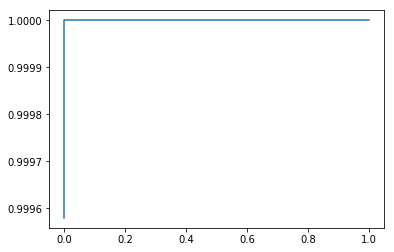

In [61]:
# Random Forest
rf = RandomForestClassifier()
rf.fit(tr[cls], tr['High_Utilizer'])

probs_rf = rf.predict_proba(ts[cls])[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(ts['High_Utilizer'], probs_rf)
auc_rf=auc(fpr_rf, tpr_rf)
print(auc_rf)
plt.plot(fpr_rf, tpr_rf)